<a href="https://colab.research.google.com/github/Suvish13/Fuzzy-C-Means-Clustering_for-Groundwaterpotentialzone-mapping/blob/main/Land_Suitability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/data

In [2]:
!pip install rasterio scikit-fuzzy matplotlib tqdm
!apt-get install -y gdal-bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.

In [13]:
import os
import glob
from tqdm import tqdm
import subprocess

input_dir = "/content/data"
resize_dir = "/content/Resize"
os.makedirs(resize_dir, exist_ok=True)

print("resize rasters")

for raster_path in tqdm(glob.glob(f"{input_dir}/*.tif")):
    file_name = os.path.basename(raster_path)
    fixed_path = os.path.join(resize_dir, file_name)

    cmd = f"gdal_translate -of GTiff -co COMPRESS=LZW \"{raster_path}\" \"{fixed_path}\""
    subprocess.run(cmd, shell=True)

print(f"Fixed rasters saved to {resize_dir}")


resize rasters


100%|██████████| 14/14 [00:01<00:00,  8.67it/s]

Fixed rasters saved to /content/Resize


14 rasters aligned
Running Fuzzy C-Means clustering
Clustering done - FPC = 0.587

 Mean normalized factor values per cluster:
Cluster 0: {'Soil.tif': np.float64(0.503), 'PH.tif': np.float64(0.687), 'Slope.tif': np.float64(0.753), 'Rainfall.tif': np.float64(0.582), 'BSI.tif': np.float64(0.501), 'DD.tif': np.float64(0.454), 'NDVI.tif': np.float64(0.893), 'Clay.tif': np.float64(0.819), 'Nitrogen.tif': np.float64(0.633), 'Elevation.tif': np.float64(0.502), 'LULC.tif': np.float64(0.651), 'Moisture.tif': np.float64(0.79), 'SOC.tif': np.float64(0.691), 'LST.tif': np.float64(0.475)}
Cluster 1: {'Soil.tif': np.float64(0.362), 'PH.tif': np.float64(0.675), 'Slope.tif': np.float64(0.62), 'Rainfall.tif': np.float64(0.352), 'BSI.tif': np.float64(0.852), 'DD.tif': np.float64(0.526), 'NDVI.tif': np.float64(0.541), 'Clay.tif': np.float64(0.924), 'Nitrogen.tif': np.float64(0.609), 'Elevation.tif': np.float64(0.265), 'LULC.tif': np.float64(0.394), 'Moisture.tif': np.float64(0.485), 'SOC.tif': np.float64

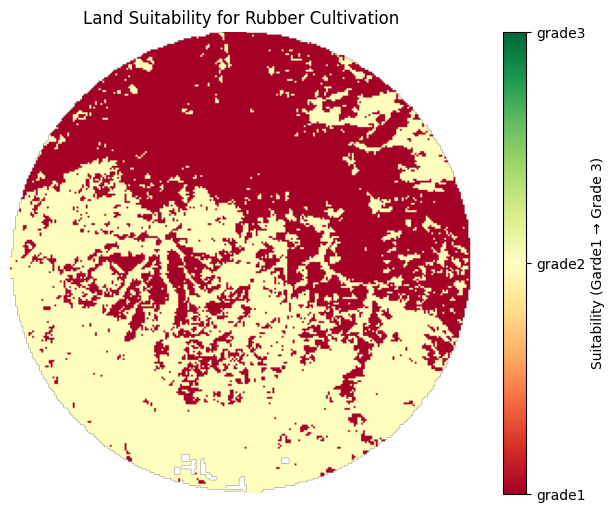

In [15]:
import os
import glob
import csv
import math
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

input_dir = resize_dir
output_dir = "Output"
os.makedirs(output_dir, exist_ok=True)

reference_raster = os.path.join(input_dir, "LULC.tif")
n_clusters = 3

weights = {
    "Rainfall": 0.257685249044588,
    "Drainage": 0.0240218620640643,
    "NDVI": 0.00769757125470432,
    "BSI": 0.00659174363471755,
    "Nitrogen": 0.0129892411685772,
    "LST": 0.194570685188148,
    "PH": 0.108073577423534,
    "Slope": 0.0324378522379726,
    "Soil": 0.0800017718588412,
    "SOC": 0.0177547467477453,
    "Claycontent": 0.00973768813579142,
    "Landuse": 0.145411788185141,
    "Soil moisture": 0.0592092551983244
}

influence = {
    "Rainfall": "positive",
    "Drainage": "negative",
    "NDVI": "positive",
    "BSI": "positive",
    "Nitrogen": "positive",
    "LST": "negative",
    "PH": "positive",
    "Slope": "negative",
    "Soil": "positive",
    "SOC": "positive",
    "Claycontent": "negative",
    "Landuse": "positive",
    "Soil moisture": "positive"
}


weights_norm = {k.lower(): v for k, v in weights.items()}
influence_norm = {k.lower(): v for k, v in influence.items()}

def filename_to_key(fname):
    base = os.path.splitext(os.path.basename(fname))[0].strip().lower()
    alias_map = {
        "dd": "drainage",
        "dd.tif": "drainage",
        "drainage": "drainage",
        "clay": "claycontent",
        "clay.tif": "claycontent",
        "claycontent": "claycontent",
        "lulc": "landuse",
        "ludc": "landuse",
        "landuse": "landuse",
        "moisture": "soil moisture",
        "soil_moisture": "soil moisture",
        "soilmoisture": "soil moisture",
        "slope": "slope",
        "lst": "lst",
        "ndvi": "ndvi",
        "bsi": "bsi",
        "nitrogen": "nitrogen",
        "ph": "ph",
        "soil": "soil",
        "soc": "soc",
        "rainfall": "rainfall",
        "elevation": "elevation",
        "elev": "elevation"
    }
    if base in alias_map:
        return alias_map[base]
    for k in weights_norm:
        if k in base or base in k:
            return k
    return base

ref = rasterio.open(reference_raster)
ref_profile = ref.profile.copy()
ref_transform, ref_crs = ref.transform, ref.crs
ref_width, ref_height = ref.width, ref.height
ref.close()

aligned_rasters = []
band_names = []

for raster in glob.glob(os.path.join(input_dir, "*.tif")):
    name = os.path.basename(raster)
    band_names.append(name)
    with rasterio.open(raster) as src:
        data = src.read(1).astype(np.float32)
        try:
            nod = src.nodata
            if nod is not None:
                data[data == nod] = np.nan
        except Exception:
            pass

        dst_data = np.full((ref_height, ref_width), np.nan, dtype=np.float32)

        if any(x in name.lower() for x in ["lulc", "landuse", "soil", "geology", "ludc", "class"]):
            resample_method = Resampling.nearest
        else:
            resample_method = Resampling.bilinear

        reproject(
            source=data,
            destination=dst_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=resample_method
        )
        aligned_rasters.append(dst_data)

print(f"{len(aligned_rasters)} rasters aligned")

def normalize(arr):
    arr_flat = arr.flatten()
    arr_nonan = arr_flat[~np.isnan(arr_flat)]
    if arr_nonan.size == 0:
        return np.full_like(arr, np.nan, dtype=np.float32)
    a_min, a_max = np.nanmin(arr), np.nanmax(arr)
    if np.isclose(a_max, a_min):

        return np.where(np.isnan(arr), np.nan, 0.0).astype(np.float32)
    return ((arr - a_min) / (a_max - a_min)).astype(np.float32)

stack = np.stack(aligned_rasters, axis=0)
mask = np.any(np.isnan(stack), axis=0)
norm_stack = np.array([normalize(band) for band in stack])
n_bands, rows, cols = norm_stack.shape

data = norm_stack.reshape(n_bands, -1)
data = np.where(np.isnan(data), 0, data)

print("Running Fuzzy C-Means clustering")
cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None
)
print(f"Clustering done - FPC = {fpc:.3f}")

cluster_map = np.argmax(u, axis=0).reshape(rows, cols)

cluster_map = np.where(mask, np.nan, cluster_map)

means = []
for k in range(n_clusters):
    mask_k = (cluster_map == k)
    band_means = []
    for i in range(n_bands):
        vals = norm_stack[i][mask_k]
        if vals.size == 0:
            band_means.append(np.nan)
        else:
            band_means.append(np.nanmean(vals))
    means.append(band_means)
means = np.array(means)

print("\n Mean normalized factor values per cluster:")
for i, vals in enumerate(means):
    print(f"Cluster {i}: {dict(zip(band_names, np.round(vals,3)))}")

cluster_scores = np.zeros(n_clusters, dtype=float)
weight_sums_per_cluster = np.zeros(n_clusters, dtype=float)

for i, name in enumerate(band_names):
    key_raw = filename_to_key(name)
    key = key_raw.lower()
    if key not in weights_norm:
        print(f" No weight defined for {name} (mapped - '{key_raw}'), skipping.")
        continue
    w = weights_norm[key]
    inf = influence_norm.get(key, "positive")
    for k in range(n_clusters):
        val = means[k, i]
        if val is None or (isinstance(val, float) and math.isnan(val)):
            continue
        if inf == "positive":
            cluster_scores[k] += val * w
        else:

            cluster_scores[k] += (1.0 - val) * w
        weight_sums_per_cluster[k] += w

for k in range(n_clusters):
    if weight_sums_per_cluster[k] > 0:
        cluster_scores[k] = cluster_scores[k] / weight_sums_per_cluster[k]
    else:
        cluster_scores[k] = np.nan

print("\n Weighted cluster scores:", np.round(cluster_scores, 3))

ranking = np.argsort(cluster_scores)
labels = [ "grade1", "grade2", "grade3"]
rank_positions = np.argsort(np.argsort(cluster_scores))
if n_clusters > 1:
    scaled_positions = np.round(rank_positions * (len(labels) - 1) / (n_clusters - 1)).astype(int)
else:
    scaled_positions = np.array([len(labels) // 2], dtype=int)
cluster_label_index = {k: scaled_positions[k] for k in range(n_clusters)}

label_map = np.full_like(cluster_map, np.nan, dtype=np.float32)
for k in range(n_clusters):
    lbl_idx = cluster_label_index[k]
    label_value = lbl_idx + 1
    label_map[cluster_map == k] = float(label_value)

out_path = os.path.join(output_dir, "Suitability_Map.tif")
ref_profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)
with rasterio.open(out_path, "w", **ref_profile) as dst:
    dst.write(label_map, 1)

print(f"\n Weighted & labeled suitable raster saved → {out_path}")
print("Label index -> label name mapping:")
for i, lab in enumerate(labels):
    print(f" {i+1}: {lab}")

csv_path = os.path.join(output_dir, "cluster_summary.csv")
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Cluster", "Weighted Score", "Label Index", "Label Name"] + band_names)
    for i in range(n_clusters):
        lbl_idx = cluster_label_index[i]
        writer.writerow([
            i,
            np.round(cluster_scores[i], 4) if not np.isnan(cluster_scores[i]) else "NaN",
            lbl_idx + 1,
            labels[lbl_idx]
        ] + list(np.round(means[i], 4)))
print(f" Cluster summary CSV saved → {csv_path}")

plt.figure(figsize=(8, 6))
plt.imshow(label_map, cmap="RdYlGn", vmin=1, vmax=len(labels))
cbar = plt.colorbar(ticks=range(1, len(labels) + 1))
cbar.set_label("Suitability (Garde1 → Grade 3)")
cbar.set_ticklabels(labels)
plt.title("Land Suitability for Rubber Cultivation")
plt.axis("off")
plt.show()
